<a href="https://colab.research.google.com/github/SCCSMARTCODE/Deep-Learning-00/blob/main/FashionMNIST/FashionMNIST_simple_conv_vs3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cifar 100 project**

In [1]:
import torchvision
import matplotlib.pyplot as plt
from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD
import random
import os

PATH="/content/drive/MyDrive/Deep Learning/fashionMNIST/"

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("CPU is available")

GPU is available


In [5]:
raw_training_dataset = torchvision.datasets.FashionMNIST(root=PATH, transform=torchvision.transforms.ToTensor(), train=True)
raw_testing_dataset = torchvision.datasets.FashionMNIST(root=PATH, transform=torchvision.transforms.ToTensor(), train=False)

train_dataset, val_dataset = random_split(raw_training_dataset, [55000, 5000])
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)
testing_loader =  DataLoader(raw_testing_dataset, batch_size=128, shuffle=True)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class FashionMNIST(nn.Module):

    def __init__(self):
        super(FashionMNIST, self).__init__()
        self.loss_function=nn.CrossEntropyLoss()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3200, 10)
        )

    def forward(self, input):
        out = self.conv(input)
        out = self.fc_layer(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        pred = self(images)
        loss = self.loss_function(pred, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        pred = self(images)
        # print(pred[:2], labels[:2])
        loss = self.loss_function(pred, labels)
        acc = self.accuracy(pred, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.tensor(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    @staticmethod
    def accuracy(pred, labels):
        right_pred_count = 0
        indices = torch.max(pred, dim=1)[1]
        for index, label in zip(indices, labels):
            if index == label:
                right_pred_count += 1
        return right_pred_count / len(labels)


    def epoch_end(self, epoch, result):
        print('Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, result['val_loss'], result['val_acc']))


model = FashionMNIST()
model.to(device)

FashionMNIST(
  (loss_function): CrossEntropyLoss()
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=10, bias=True)
  )
)

In [7]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [8]:
def train(epochs, lr, model, train_loader, val_loader, opt=SGD):
    history = []
    optimizer = opt(model.parameters(), lr)
    for epoch in range(epochs):
    # batch training
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        torch.save(model.state_dict(), os.path.join(PATH, "parameters_fully_connected_version2.pth"))
    return history


In [10]:
history1 = train(10, 0.2, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4853, val_acc: 0.8291
Epoch [1], val_loss: 0.3770, val_acc: 0.8615
Epoch [2], val_loss: 0.2986, val_acc: 0.8896
Epoch [3], val_loss: 0.3208, val_acc: 0.8844
Epoch [4], val_loss: 0.2976, val_acc: 0.8951
Epoch [5], val_loss: 0.3098, val_acc: 0.8854
Epoch [6], val_loss: 0.2654, val_acc: 0.9057
Epoch [7], val_loss: 0.2893, val_acc: 0.8939
Epoch [8], val_loss: 0.2679, val_acc: 0.9053
Epoch [9], val_loss: 0.2594, val_acc: 0.9092


In [12]:
history2 = train(10, 0.02, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2277, val_acc: 0.9217
Epoch [1], val_loss: 0.2279, val_acc: 0.9219
Epoch [2], val_loss: 0.2284, val_acc: 0.9191
Epoch [3], val_loss: 0.2480, val_acc: 0.9195
Epoch [4], val_loss: 0.2312, val_acc: 0.9217
Epoch [5], val_loss: 0.2274, val_acc: 0.9201
Epoch [6], val_loss: 0.2295, val_acc: 0.9229
Epoch [7], val_loss: 0.2226, val_acc: 0.9244
Epoch [8], val_loss: 0.2217, val_acc: 0.9234
Epoch [9], val_loss: 0.2253, val_acc: 0.9227


In [11]:
evaluate(model, val_loader)

{'val_loss': 0.2623099386692047, 'val_acc': 0.9085937738418579}

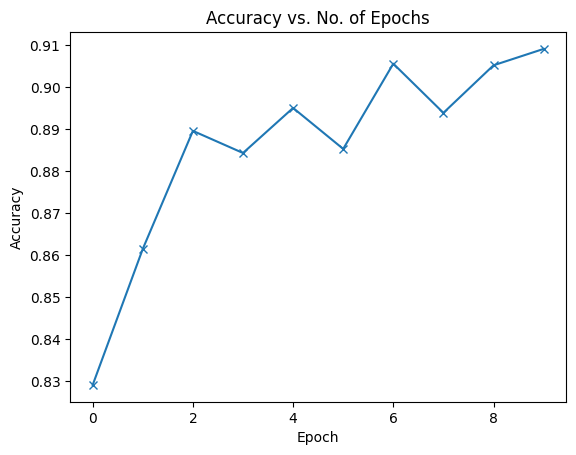

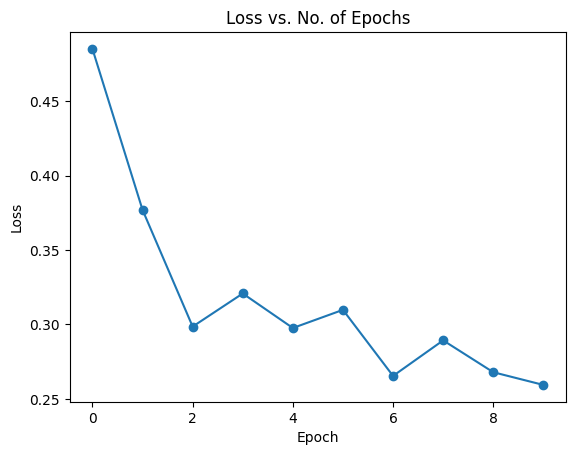

In [13]:
history = history1
accuracies = [result['val_acc'] for result in history]
losses = [result['val_loss'] for result in history]

# Plot for Accuracy
plt.figure(1)
plt.plot(accuracies, '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. No. of Epochs')

# Plot for Loss
plt.figure(2)
plt.plot(losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. No. of Epochs')

plt.show()